In [1]:
import sys
import os

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import pandas as pd
import numpy as np 
from utils.utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts,load_init_trainer,match_period_coverage_with_netmob
from trainer import MultiModelTrainer, Trainer
from K_fold_validation.K_fold_validation import KFoldSplitter
from constants.config import get_args,update_modif
from utils.save_results import build_results_df
from constants.paths import folder_path,file_name
from plotting.plotting import plot_k_fold_split

# ==== GET PARAMETERS ====
model_name ='DCRNN' #'MTGNN' # 'STGCN'  #'CNN' # 
args = get_args(model_name)

# Modification :
args.epochs = 2
args.W = 0
args.K_fold = 5   # Means we will use the first fold for the Ray Tuning and the 4 other ones to get the metrics
args.ray = False
args.loss_function_type = 'quantile'  #'MSE' #

update_modif(args)

coverage = match_period_coverage_with_netmob(file_name)

# Choose DataSet and VisionModel if needed: 
dataset_names = ['subway_in'] # ['calendar','netmob'] #['subway_in','netmob','calendar']
vision_model_name = 'FeatureExtractor_ResNetInspired'  # 'ImageAvgPooling'  #'FeatureExtractor_ResNetInspired' #'MinimalFeatureExtractor',

'pynvml' is not available on this environment.
Model: DCRNN, K_fold = 5
!!! Loss function: quantile 


# Sliding Window Cross Validation 
## Define fixed Dataset K_fold split for each trial: 

In [2]:
folds = list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(dataset_names,args,coverage,folder_path,file_name,vision_model_name,folds)
K_subway_ds,dic_class2rpz = K_fold_splitter.split_k_fold()

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00

Init Subway-In Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 


U size:  torch.Size([6719, 40, 7]) Utarget size:  torch.Size([6719, 40, 1])
U_train size:  torch.Size([3912, 40, 7]) Utarget_train size:  torch.Size([3912, 40, 1])
U_valid size:  torch.Size([1304, 40, 7]) Utarget_valid size:  torch.Size([1304, 40, 1])
U_test size:  torch.Size([1310, 40, 7]) Utarget_test size:  torch.Size([1310, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1760.)

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor

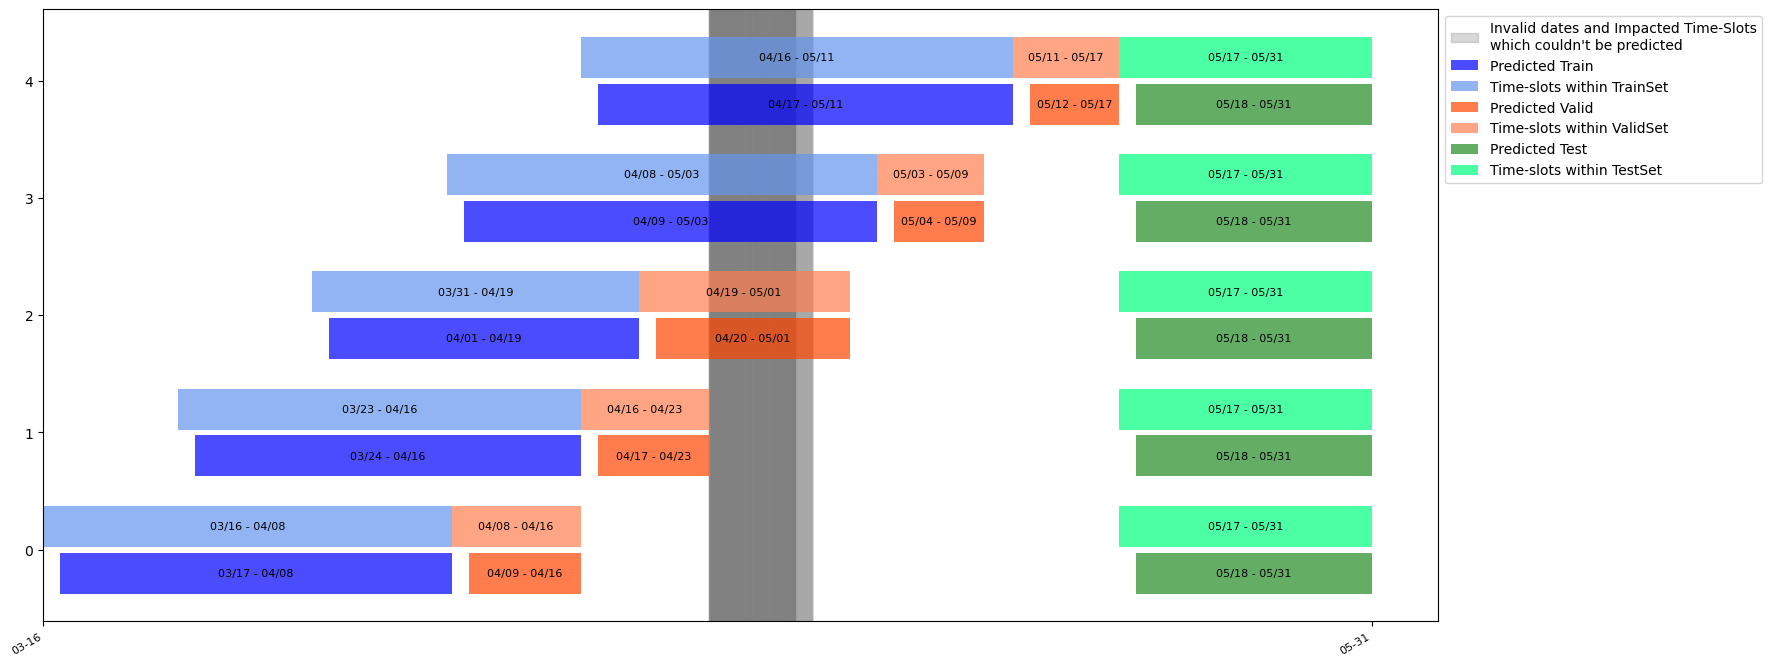

In [3]:
from plotting.plotting import plot_k_fold_split
plot_k_fold_split(K_subway_ds,K_subway_ds[0].init_invalid_dates)

In [6]:
# Load dataset and invalid_dates
dataset,invalid_dates = get_DataSet_and_invalid_dates(args.abs_path,folder_path,file_name,args.W,args.D,args.H,args.step_ahead,single_station = False)

# Train / Valid / Test split and Normalize for K-fold 
(Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz,dic_rpz2class,nb_words_embedding) =  dataset.split_K_fold(args,invalid_dates)$







# Plot information about split and folds:
plot_k_fold_split(Datasets,invalid_dates)

Time-step per hour: 4.0
coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00


AttributeError: 'DataSet' object has no attribute 'split_K_fold'

In [2]:
results_df = pd.DataFrame()
#save_dir = get_save_directory(args)

Datasets,DataLoader_list,dic_class2rpz,nb_words_embedding,time_slots_labels,dic_rpz2class = load_init_trainer(folder_path,file_name,args)
(loss_function,Model_list,Optimizer_list,Scheduler_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz,n_vertex = len(Datasets[0].columns))
Datasets,DataLoader_list,Model_list,Optimizer_list,Scheduler_list = Datasets[1:],DataLoader_list[1:],Model_list[1:],Optimizer_list[1:],Scheduler_list[1:]

multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,Scheduler_list,args_embedding=args_embedding,save_dir = save_dir,dic_class2rpz=dic_class2rpz)

(results_by_fold,mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds) = multimodeltrainer.K_fold_validation(mod_plot = 10)
results_by_fold.to_csv(f"{save_dir}results_by_fold.csv")

# Svae results 
results_df = build_results_df(results_df,args, mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds)
results_df.to_csv(f"{args.model_name}_{args.loss_function_type}_H{args.H}_D{args.D}_W{args.W}_E{args.epochs}_K_fold{args.K_fold}_Emb_dim{args.embedding_dim}FC1_17_8_FC2_8_4_save_results.csv")

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0


K_fold 0
start training
epoch: 0 
 min\epoch : 0.04
Estimated time for training: 3.6min 


/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


K_fold 1
start training
epoch: 0 
 min\epoch : 0.04
Estimated time for training: 3.5min 


/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


K_fold 2
start training
epoch: 0 
 min\epoch : 0.04
Estimated time for training: 3.9min 


/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


KeyboardInterrupt: 

# Get Parameters : 

In [ ]:
# Load config
model_name = 'STGCN' #'CNN' 
args = get_args(model_name)
#args = get_args(model_name = model_name,learn_graph_structure = True)  # MTGNN

# Modification : 
args.epochs = 1
args.K_fold = 1

args.loss_function_type = 'MSE'
args.out_dim = 1
args.alpha = None
# Save Directory:
#main_dir = get_save_directory(args)

# Test complet sur les 3 Top STGCN, avec sauvegarde du model :

In [ ]:
results_df = pd.DataFrame()

#for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3,1,3],['input','input','input'],[True,True,False],['tuple','tuple','tuple'])):
for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3],['input'],[True],['tuple'])):

    args.calendar_class = calendar_class
    args.position = position
    args.specific_lr = specific_lr
    args.type_calendar = type_calendar

    save_dir = get_save_directory(args)

    # Load dataset and invalid_dates 
    dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,args.W,args.D,args.H,args.step_ahead,single_station = False)
    (Datasets,DataLoader_list,time_slots_labels,dic_class2rpz,dic_rpz2class,nb_words_embedding) =  dataset.split_K_fold(args,invalid_dates)
    
    # Load associated K_folds Models: 
    (loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz)
    multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False,save_dir = save_dir,dic_class2rpz=dic_class2rpz)
    (results_by_fold,mean_picp,mean_mpiw,dict_last,dict_scores) = multimodeltrainer.K_fold_validation(mod_plot = 1)
    results_by_fold.to_csv(f"{save_dir}results_by_fold.csv")
    
    # Svae results 
    results_df = build_results_df(results_df,args, mean_picp,mean_mpiw,dict_last,dict_scores)
                            
results_df.to_csv('save_results.csv')
results_df

In [ ]:
# ==== GET PARAMETERS ====
# Load config
model_name = 'STGCN' #'CNN' 
args = get_args(model_name)
#args = get_args(model_name = model_name,learn_graph_structure = True)  # MTGNN

# Modification : 
args.epochs = 300

# Save Directory:
#main_dir = get_save_directory(args)
args.H = 0
args.W = 0
args.D = 0
args.L =args.H+args.W+args.D
args.single_station = True
# ==== TEST  ====
for K_fold in [5]:
    args.K_fold = K_fold
    results_df = pd.DataFrame()

    #for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3,1,3],['input','input','input'],[True,True,False],['tuple','tuple','tuple'])):
    #for i,(calendar_class,position,specific_lr, type_calendar) in enumerate(zip([3],['input'],[True],['tuple'])):
    for i,(embedding_dim,calendar_class,position,specific_lr, type_calendar,time_embedding) in enumerate(zip([3], # None
                                                                                                             [3], # 3
                                                                                               ['input'], # None
                                                                                               [False], # None 
                                                                                               ['tuple'], # None
                                                                                               [True] # False
                                                                                              )
                                                                                            ):
        args.embedding_dim = embedding_dim
        args.calendar_class = calendar_class
        args.position = position
        args.specific_lr = specific_lr
        args.type_calendar = type_calendar
        args.time_embedding = time_embedding

        #save_dir = get_save_directory(args)

        # Load dataset and invalid_dates 
        dataset,invalid_dates = get_DataSet_and_invalid_dates(folder_path,file_name,args.W,args.D,args.H,args.step_ahead,single_station = args.single_station)
        (Datasets,DataLoader_list,time_slots_labels,dic_class2rpz,dic_rpz2class,nb_words_embedding) =  dataset.split_K_fold(args,invalid_dates)

        # Load associated K_folds Models: 
        (loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz)
        multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,scheduler = None,args_embedding=args_embedding,ray= False,save_dir = save_dir,dic_class2rpz=dic_class2rpz)
        
        (results_by_fold,mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds) = multimodeltrainer.K_fold_validation(mod_plot = 10)
        results_by_fold.to_csv(f"{save_dir}results_by_fold.csv")

        # Svae results 
        results_df = build_results_df(results_df,args, mean_picp,mean_mpiw,dict_last_from_mean_of_folds,dict_best_from_mean_of_folds)
        results_df.to_csv(f"{args.model_name}_H{args.H}_D{args.D}_W{args.W}_E{args.epochs}_K_fold{args.K_fold}_Emb_dim{args.embedding_dim}FC1_17_8_FC2_8_4_save_results.csv")